In [2]:
import numpy as np
import pandas as pd
import time

conn = "postgresql://jfghdjfkghjkdfg:skdjfhdskfhj@" # данные изменены
uri = "postgres.dfkjfksjhfgd:6432/dsfs" # данные изменены
conn_uri = conn + uri

# RecSys Контентный подход

### Загрузка данных

In [3]:
df_users = pd.read_sql("SELECT * FROM user_data", conn_uri)

In [4]:
df_users.head(2)

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads


In [5]:
df_posts = pd.read_sql("SELECT * FROM post_text_df", conn_uri)

In [6]:
df_posts.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Преобразование текста в признаки с использованием TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
txt_tfidf = vectorizer.fit_transform(df_posts['text'])

# Понижение размерности при помощи TruncatedSVD
# svd = TruncatedSVD(n_components=10, random_state=42) # kernel died
svd = TruncatedSVD(n_components=5, random_state=42)
txt_tfidf_svd = svd.fit_transform(txt_tfidf)

In [8]:
# проверяем проверяем структуру признаков
txt_tfidf_svd[:,0]

array([0.6643565 , 0.68032537, 0.71740028, ..., 0.44740764, 0.57517416,
       0.50729007])

In [9]:
# Добавляем новые признаки к исходному датасету
for i in range(5):
    new_col = 'idf_svd' + str(i)
    df_posts[new_col] = txt_tfidf_svd[:,i]

In [10]:
# Контроль
df_posts.head(2)

,post_id,text,topic,idf_svd0,idf_svd1,idf_svd2,idf_svd3,idf_svd4
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.664357,-0.059180,-0.290901,0.113198,-0.028977
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.680325,-0.041336,-0.306858,-0.006451,-0.005135


### Загрузка/выгрузка постов с новыми признаками в базу данных

In [11]:
from sqlalchemy import create_engine

# данные изменены
engine = create_engine(
    "postgresql://jfghdjfkghjkdfg:skdjfhdskfhj@"
    "postgres.dfkjfksjhfgd:6432/dsfs"
)

In [6]:
# # # WARNING --- DROP TABLE !!!
# Удаляем таблицу признаков при обновлении датасета

# sql = 'DROP TABLE IF EXISTS table_idf_posts'
# result = engine.execute(sql)
# result

In [7]:
# # # записываем таблицу признаков

# df_posts.to_sql('table_idf_posts', con=engine)

# # 1.45...1.53

In [13]:
# считываем таблицу признаков table_idf_posts

df_posts_from_sql = pd.read_sql('SELECT * FROM table_idf_posts',
                 con=engine, index_col='index')

# 0.4...0.8

**кол-во реакций на 1 пользователя** (понадобится для приложения):

In [14]:
query_text = '''SELECT user_id, count(*)
                FROM feed_data
                GROUP BY user_id'''

In [15]:
df_feeds_uids = pd.read_sql(query_text, conn_uri)

In [16]:
df_feeds_uids.sort_values('count').head(1)

,user_id,count
143449,148786,128


In [17]:
df_feeds_uids.sort_values('count').tail(1)

,user_id,count
89410,93426,970


**Таким образом реакций от 128 до 970 на пользователя**

Дальше необходимо загрузить данные из таблицы feed_data.
Количество записей в таблице - около 77 млн.

In [18]:
query_text = "SELECT count(*) FROM feed_data"
df_feeds = pd.read_sql(query_text, conn_uri)
df_feeds.head()

,count
0,76892800


Имеется ограничение на объем доступной памяти, поэтому можем выгрузить только небольшую часть, не нарушающую ограничение, но достаточную для обучения модели.  
P.S. Как выяснилось в ходе экспериментов, на качество обучения модели влиял не только размер (который был очень важен), но и способ выборки.

Опыты показали, что даже подзапросы с использованием оконных функций для выбора всех пользователей с максимальным количеством их реакций и с искуственным балансом классов по реакциям получились не так эффективны для обучения модели, как выборка максимального количества абсолютно случайных записей.

In [19]:
# --- 3000000-5000000 - kernel died, 2000000 - frozen
# Берем 1 500 000 СЛУЧАЙНЫХ записей
query_text = '''SELECT user_id, post_id, target
                FROM feed_data
                ORDER BY random() LIMIT 1500000'''

In [20]:
start = time.time()

df_feeds = pd.read_sql(query_text, conn_uri)

time.time() - start

# 138

111.88418340682983

In [21]:
df_feeds.columns

Index(['user_id', 'post_id', 'target'], dtype='object')

In [22]:
df_feeds.shape

(1500000, 3)

**Баланс классов в target**:

In [23]:
df_feeds.target.value_counts()

# 0    1339144 -- 15e5 fds -- w/o balanse
# 1     160856

0    1340196
1     159804
Name: target, dtype: int64

### Общая статистика

**users**

In [16]:
# df_users.info()

# user_id      163205
# gender            2
# age              76
# country          11 # cat
# city           3915 # cat
# exp_group         5
# os                2 # ohe # cat
# source            2 # ohe # cat
# dtype: int64

### posts

In [34]:
# df_posts.nunique()

# post_id    7023
# text       6924 # cat
# topic         7 # cat
# dtype: int64

In [24]:
# # кол-во постов по темам (понадобится для оптимизации логики приложения)
df_posts.groupby('topic').agg({'post_id': ['count']}).reset_index()

,topic,post_id
,,count
0,business,510
1,covid,1799
2,entertainment,386
3,movie,3000
4,politics,417
5,sport,510
6,tech,401


### feeds

In [25]:
df_feeds.nunique()

user_id    162475
post_id      6831
target          2
dtype: int64

Случайной выборкой получили бОльшую часть юзеров и постов.

In [26]:
# проверка на пропуски
df_feeds.isnull().sum().sum()

0

# Собираем в 1 фрейм

In [27]:
# WARNING: с полем text общий фрейм не проходит ограничение по памяти

df = pd.merge(df_feeds, df_posts.drop('text', axis=1),
              left_on='post_id', right_on='post_id')

In [28]:
df = pd.merge(df, df_users, left_on='user_id',
              right_on='user_id')

In [29]:
df.head(2)

,user_id,post_id,target,topic,idf_svd0,idf_svd1,idf_svd2,idf_svd3,idf_svd4,gender,age,country,city,exp_group,os,source
0,119134,5730,0,movie,0.535399,-0.052456,0.107855,-0.167386,0.043518,0,22,Finland,Mikkeli,4,iOS,organic
1,119134,6630,0,movie,0.394182,-0.049298,0.297815,-0.206414,0.057301,0,22,Finland,Mikkeli,4,iOS,organic


In [30]:
df.shape

(1500000, 16)

In [31]:
# проверка на пропуски
df.isnull().sum().sum()

0

In [32]:
# Смотрим типы данных для категоризации признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500000 entries, 0 to 1499999
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1500000 non-null  int64  
 1   post_id    1500000 non-null  int64  
 2   target     1500000 non-null  int64  
 3   topic      1500000 non-null  object 
 4   idf_svd0   1500000 non-null  float64
 5   idf_svd1   1500000 non-null  float64
 6   idf_svd2   1500000 non-null  float64
 7   idf_svd3   1500000 non-null  float64
 8   idf_svd4   1500000 non-null  float64
 9   gender     1500000 non-null  int64  
 10  age        1500000 non-null  int64  
 11  country    1500000 non-null  object 
 12  city       1500000 non-null  object 
 13  exp_group  1500000 non-null  int64  
 14  os         1500000 non-null  object 
 15  source     1500000 non-null  object 
dtypes: float64(5), int64(6), object(5)
memory usage: 194.5+ MB


In [33]:
df.nunique()

user_id      162475
post_id        6831
target            2
topic             7
idf_svd0       6634
idf_svd1       6634
idf_svd2       6634
idf_svd3       6634
idf_svd4       6634
gender            2
age              76
country          11
city           3911
exp_group         5
os                2
source            2
dtype: int64

In [29]:
# country      11 # cat
# city       3915 # cat
# os            2 # ohe # cat
# source        2 # ohe # cat
# topic         7 # ohe # cat

### Тренируем модель

In [34]:
# уберем лишнее
df_learn = df.drop(['user_id', 'post_id'], axis=1)

X = df_learn.drop('target', axis=1)
y = df_learn['target']

In [35]:
### Делим выборку на train и test

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [36]:
X_train.head(2)

,topic,idf_svd0,idf_svd1,idf_svd2,idf_svd3,idf_svd4,gender,age,country,city,exp_group,os,source
1479071,entertainment,0.619500,-0.056086,-0.252435,-0.167565,0.051345,1,20,Russia,Chita,4,Android,ads
59650,sport,0.549701,-0.031583,0.038362,-0.157675,0.032571,0,21,Russia,Moscow,0,Android,organic


In [37]:
X_train.shape

(1200000, 13)

In [19]:
from catboost import CatBoostClassifier

# Выделяем колонки, которые передадим в catboost как категориальные
cat_cols = ['topic', 'country', 'city', 'os', 'source']

catboost = CatBoostClassifier(verbose=50)

# Параметры, определенные в ходе длительных экспериментов с GreedSearchCV
catboost.set_params(depth=12, learning_rate=0.18, auto_class_weights='Balanced',
                    iterations=500, border_count=200, l2_leaf_reg=3)

start = time.time()

catboost.fit(X_train, y_train, cat_features=cat_cols)

time.time() - start

# ~23m -- X_train 1 200 000, 13 -- 15e5 fds -- w/o blns -- wth idf

0:	learn: 0.6861138	total: 2.94s	remaining: 24m 24s
50:	learn: 0.6462403	total: 1m 52s	remaining: 16m 29s
100:	learn: 0.6241162	total: 4m 1s	remaining: 15m 54s
150:	learn: 0.5999053	total: 6m 26s	remaining: 14m 53s
200:	learn: 0.5781627	total: 8m 46s	remaining: 13m 2s
250:	learn: 0.5579794	total: 11m 7s	remaining: 11m 2s
300:	learn: 0.5387207	total: 13m 20s	remaining: 8m 49s
350:	learn: 0.5206320	total: 15m 40s	remaining: 6m 39s
400:	learn: 0.5045636	total: 18m 1s	remaining: 4m 27s
450:	learn: 0.4911308	total: 20m 20s	remaining: 2m 12s
499:	learn: 0.4764763	total: 22m 39s	remaining: 0us


1374.9825041294098

In [20]:
# Подсчет F1-меры c использованием параметра average='weighted'
f1_score(y_test, catboost.predict(X_test), average='weighted')

0.7244684552274631

In [21]:
# смотрим метрики
print(classification_report(y_test, catboost.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.918     0.683     0.783    268001
           1      0.155     0.486     0.235     31999

    accuracy                          0.662    300000
   macro avg      0.536     0.585     0.509    300000
weighted avg      0.836     0.662     0.724    300000



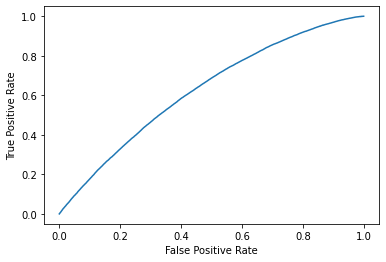

In [23]:
# строим RocCurve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [24]:
# считаем auc
round(auc(fpr, tpr), 3)

0.627

In [25]:
# смотрим признаки, наиболее повлиявшие на качество
catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,city,12.912971
1,age,11.522032
2,idf_svd2,9.818033
3,idf_svd3,9.124841
4,exp_group,9.002440
5,idf_svd1,8.855447
6,idf_svd0,8.513844
7,idf_svd4,7.685789
8,topic,5.636066
9,gender,5.620414


(!) Признаки, полученные из текстов, имеют высокое влияние даже после драматического понижения размерности.

In [26]:
# Запись модели в файл

catboost.save_model('model_catboost')

### Тестовое применение обученной модели для выдачи рекомендаций пользователю

Делаем рекомендацию по user_id:

In [38]:
# делаем рекомендацию на произвольном user_id
get_user_id = 201

Данные выбранного user_id:

In [39]:
user_cols = ['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source']
cur_user_data = df_users[df_users['user_id'] == get_user_id]
cur_user_data = cur_user_data.drop('user_id', axis=1)
cur_user_data

,gender,age,country,city,exp_group,os,source
1,0,37,Russia,Abakan,0,Android,ads


Собираем фрейм под заданного юзера:

In [42]:
temp_df = pd.DataFrame()
specific_df = df_posts
# # при получении готовых признаков из базы:
# specific_df = df_posts_from_sql

# добавляем во фрейм для предсказания данные выбранного пользователя
for col in user_cols:
    specific_df[col] = cur_user_data[col].values[0]

specific_df.head(2)
# topic gender age country city exp_group os source

,post_id,text,topic,idf_svd0,idf_svd1,idf_svd2,idf_svd3,idf_svd4,gender,age,country,city,exp_group,os,source
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.664357,-0.059180,-0.290901,0.113198,-0.028977,0,37,Russia,Abakan,0,Android,ads
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.680325,-0.041336,-0.306858,-0.006451,-0.005135,0,37,Russia,Abakan,0,Android,ads


In [43]:
specific_df.shape

(7023, 15)

In [44]:
# уберем post_id и text для предсказания
df_for_predict = specific_df.drop(['post_id', 'text'], axis=1)
df_for_predict.head(2)

,topic,idf_svd0,idf_svd1,idf_svd2,idf_svd3,idf_svd4,gender,age,country,city,exp_group,os,source
0,business,0.664357,-0.059180,-0.290901,0.113198,-0.028977,0,37,Russia,Abakan,0,Android,ads
1,business,0.680325,-0.041336,-0.306858,-0.006451,-0.005135,0,37,Russia,Abakan,0,Android,ads


In [46]:
# При загрузке уже обученной модели:
from catboost import CatBoostClassifier

model_from_file = CatBoostClassifier()
model_from_file.load_model("model_catboost")

In [47]:
# делаем предсказание
# pred = catboost.predict_proba(df_for_predict)
pred = model_from_file.predict_proba(df_for_predict)

In [48]:
# получаем вероятности для сформированного фрейма
# и добавляем их в новую колонку
specific_df['pred'] = pred[:,1]

In [49]:
specific_df.shape

# 7023, 11 -- 0901-18:10 -- 10 fds -- w/o balanse -- w/o idf -- X_train 1 305 640, 8
# 7023, 16

(7023, 16)

In [50]:
specific_df.head(2)

,post_id,text,topic,idf_svd0,idf_svd1,idf_svd2,idf_svd3,idf_svd4,gender,age,country,city,exp_group,os,source,pred
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.664357,-0.059180,-0.290901,0.113198,-0.028977,0,37,Russia,Abakan,0,Android,ads,0.379555
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.680325,-0.041336,-0.306858,-0.006451,-0.005135,0,37,Russia,Abakan,0,Android,ads,0.408600


**Получаем топ-5 рекомендаций:**

In [51]:
top_5 = specific_df.sort_values(by='pred', ascending=False).head(5)

In [52]:
top_5

,post_id,text,topic,idf_svd0,idf_svd1,idf_svd2,idf_svd3,idf_svd4,gender,age,country,city,exp_group,os,source,pred
4121,4301,200l: A Space Odyssey is a supremely intriguin...,movie,0.819885,-0.081811,-0.058366,0.288444,-0.077132,0,37,Russia,Abakan,0,Android,ads,0.804605
569,501,HealthSouth ex-boss goes on trial\n\nThe forme...,business,0.650932,-0.024968,-0.281667,-0.104592,0.011347,0,37,Russia,Abakan,0,Android,ads,0.775332
3073,3209,"India reported 48,661 new #COVID19 positive ca...",covid,0.249333,0.713150,-0.110362,0.158846,0.142203,0,37,Russia,Abakan,0,Android,ads,0.757004
6312,6574,Bravestarr was released in 1987 by the now def...,movie,0.821616,-0.083590,-0.026574,0.159508,-0.032504,0,37,Russia,Abakan,0,Android,ads,0.743060
1146,2564,"$HGEN Humanigen, Inc. (HGEN) Expands Phase III...",covid,0.209837,0.824477,-0.021816,-0.104762,-0.440188,0,37,Russia,Abakan,0,Android,ads,0.738973
